# Разбираемся со звуком

## Импорт библиотек

In [1]:
%config Completer.use_jedi = False

In [8]:
import audiomate
from audiomate.corpus import io

import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import librosa
import librosa.display

import torch
from torch.utils.data import Dataset, DataLoader

import torchsummary

from efficientnet_pytorch import EfficientNet

In [288]:
dtype = torch.float32
device = torch.device('cuda:0')

## Посмотрим на аудио глазами ☺

In [7]:
audio_mnist = audiomate.Corpus.load('tmp/', reader='audio-mnist')
audio_mnist.all_tokens()

{'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'}

In [22]:
k, v = next(iter(audio_mnist.utterances.items()))

sr = v.sampling_rate
y = v.read_samples()
y

array([0.00045776, 0.00042725, 0.00045776, ..., 0.0005188 , 0.0005188 ,
       0.0005188 ], dtype=float32)

In [23]:
librosa.get_duration(y, sr=sr)

0.7474375

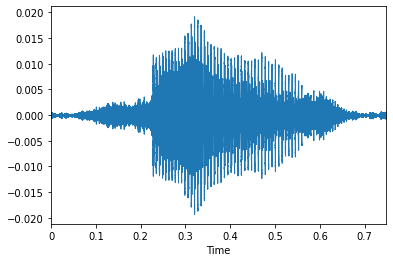

In [43]:
librosa.display.waveplot(y, sr=sr);

## Построим спектрограммы

In [44]:
n_fft = 2048
hop_length = 512

In [61]:
D = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
D.shape

(1025, 71)

In [60]:
sr // 2  # Максимальная частота в спектрограмме

24000

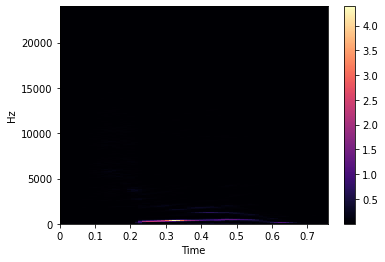

In [58]:
librosa.display.specshow(D, sr=sr, hop_length=hop_length, x_axis='time', y_axis='linear')
plt.colorbar();

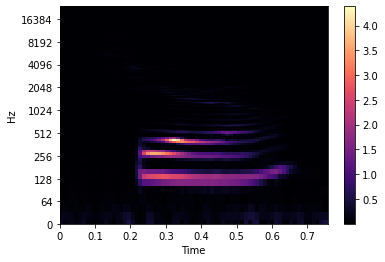

In [56]:
librosa.display.specshow(D, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
plt.colorbar();

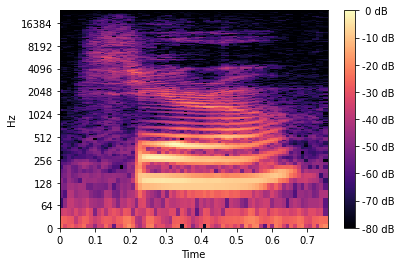

In [77]:
DB = librosa.amplitude_to_db(D, ref=np.max)
librosa.display.specshow(DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
plt.colorbar(format='%2.0f dB');

In [103]:
n_mels = 128  # 1024 // 8

In [104]:
S = librosa.feature.melspectrogram(y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

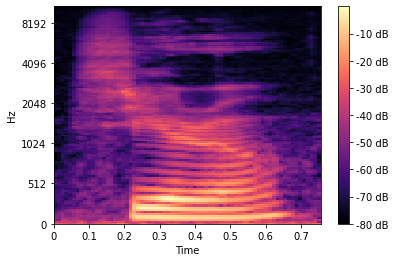

In [106]:
S_DB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');

In [107]:
S_DB.shape

(128, 71)

## Классификация цифр 0 и 1

In [108]:
def melspectrogram_for_wav(y, sr, n_fft, hop_length, n_mels):
    S = librosa.feature.melspectrogram(y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    S_DB = librosa.power_to_db(S, ref=np.max)
    return S_DB

In [420]:
class AudioMNISTDataset(Dataset):
    def __init__(self, mode, path='tmp/', train_size=0.75, random_seed=179):
        super().__init__()

        self.NUM_TIME_SAMPLES = 14073  # равно числу отсчетов у самой короткой записи

        assert mode in ('train', 'test')

        self.mode = mode
        self.train_size = train_size

        self.audio_mnist = audiomate.Corpus.load(path, reader='audio-mnist')

        self.all_keys = []
        labels = []
        for k, v in tqdm(audio_mnist.utterances.items()):
            label = int(next(iter(v.all_tokens())))
            if label in (0, 1):
                self.all_keys.append(k)
                labels.append(label)

        self.train_keys, self.test_keys = train_test_split(self.all_keys, train_size=train_size,
                                                           stratify=labels, random_state=random_seed)
        if mode == 'train':
            self.keys = self.train_keys
        else:
            self.keys = self.test_keys

        self.train_mean = -47.524658203125
        self.train_std = 18.497217178344727

    def __getitem__(self, i):
        key = self.keys[i]
        cur_utterance = self.audio_mnist.utterances[key]

        label = float(next(iter(cur_utterance.all_tokens())))

        samples = cur_utterance.read_samples()
        shift = (len(samples) - self.NUM_TIME_SAMPLES) // 2
        samples = samples[shift:shift + self.NUM_TIME_SAMPLES]
        spectrogram = melspectrogram_for_wav(samples, v.sampling_rate, n_fft, hop_length, n_mels)

        normalized_spectrogram = (spectrogram - train_mean) / train_std

        return torch.tensor(normalized_spectrogram, dtype=dtype).unsqueeze(0), label

    def __len__(self):
        return len(self.keys)

    def __repr__(self):
        return f'{self.mode} dataset, {len(self)} items'

In [423]:
train_dataset = AudioMNISTDataset(mode='train')
train_dataset

train dataset, 4500 items

In [424]:
test_dataset = AudioMNISTDataset(mode='test')
test_dataset

test dataset, 1500 items

In [426]:
train_dataset[0][0].shape

torch.Size([1, 128, 28])

In [434]:
batch_size = 64

In [437]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, )
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, )

next(iter(train_dataloader))

[tensor([[[[ 1.4395,  1.1319,  1.0179,  ...,  0.7916,  0.9508,  0.8059],
           [ 1.5716,  1.2904,  0.6180,  ...,  0.7586,  0.7288,  0.7691],
           [ 1.7644,  1.4506,  0.3405,  ...,  0.7573,  0.6329,  0.6606],
           ...,
           [-1.1083, -1.1145, -1.0765,  ..., -1.0822, -1.0487, -0.9308],
           [-1.2037, -1.1406, -1.1757,  ..., -1.0456, -1.0011, -1.0842],
           [-1.2654, -1.2464, -1.3276,  ..., -1.2366, -1.2675, -1.2338]]],
 
 
         [[[ 1.7730,  1.7745,  1.7444,  ...,  1.3837,  1.4668,  1.4942],
           [ 1.5009,  1.3634,  1.3093,  ...,  0.8173,  1.0050,  0.8074],
           [ 0.9959,  0.7563,  0.3722,  ...,  0.4856,  0.2415,  0.5965],
           ...,
           [-1.2056, -1.2051, -1.2264,  ..., -1.1349, -1.0892, -1.1237],
           [-1.1102, -1.1365, -1.2635,  ..., -1.2813, -1.2118, -1.2549],
           [-1.4045, -1.3805, -1.4398,  ..., -1.4143, -1.3336, -1.3253]]],
 
 
         [[[ 1.2568,  0.9864,  0.3436,  ...,  0.9287,  0.8467,  0.4622],
       

In [439]:
X, Y = next(iter(train_dataloader))
X.shape

torch.Size([64, 1, 128, 28])

In [440]:
Y.shape

torch.Size([64])

In [441]:
image_size = (128, 28)

In [444]:
model = EfficientNet.from_name('efficientnet-b0', in_channels=1, num_classes=1, image_size=image_size).to(device)
torchsummary.summary(model, X.shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1           [-1, 1, 130, 30]               0
Conv2dStaticSamePadding-2           [-1, 32, 64, 14]             288
       BatchNorm2d-3           [-1, 32, 64, 14]              64
MemoryEfficientSwish-4           [-1, 32, 64, 14]               0
         ZeroPad2d-5           [-1, 32, 66, 16]               0
Conv2dStaticSamePadding-6           [-1, 32, 64, 14]             288
       BatchNorm2d-7           [-1, 32, 64, 14]              64
MemoryEfficientSwish-8           [-1, 32, 64, 14]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 32, 1, 1]             288
         I

In [445]:
max_epoch = 1

criterion = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters())

In [448]:
for epoch in tqdm(range(max_epoch)):
    model.train()

    for X, y in tqdm(train_dataloader):
        optimizer.zero_grad()

        X = X.to(device)
        scores = model(X).cpu().squeeze(-1)
        loss = criterion(scores, y)

        loss.backward()
        optimizer.step()

        preds = (scores.detach().cpu() > 0).float()
        accuracy = (y == preds).float().mean()

        print(
            f'Epoch {epoch}, '
            f'loss {loss.item():12.3f}, '
            f'accuracy {accuracy.item():5.3f}'
        )

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch 0, loss        0.698, accuracy 0.500
Epoch 0, loss        0.773, accuracy 0.547
Epoch 0, loss        0.676, accuracy 0.672
Epoch 0, loss        0.585, accuracy 0.688
Epoch 0, loss        0.535, accuracy 0.656
Epoch 0, loss        0.492, accuracy 0.781
Epoch 0, loss        0.472, accuracy 0.734
Epoch 0, loss        0.355, accuracy 0.922
Epoch 0, loss        0.413, accuracy 0.828
Epoch 0, loss        0.170, accuracy 0.953
Epoch 0, loss        0.159, accuracy 0.953
Epoch 0, loss        0.378, accuracy 0.891
Epoch 0, loss        0.229, accuracy 0.906
Epoch 0, loss        0.200, accuracy 0.906
Epoch 0, loss        0.086, accuracy 0.984
Epoch 0, loss        0.054, accuracy 0.984
Epoch 0, loss        0.086, accuracy 0.953
Epoch 0, loss        0.092, accuracy 0.969
Epoch 0, loss        0.050, accuracy 0.969
Epoch 0, loss        0.045, accuracy 0.984
Epoch 0, loss        0.027, accuracy 1.000
Epoch 0, loss        0.060, accuracy 0.969
Epoch 0, loss        0.034, accuracy 0.984
Epoch 0, lo

In [449]:
scores

tensor([-4.0155, -7.1776, -2.8621, -9.3506, -4.7056, -7.0791, 11.7195, 12.8840,
         9.2380, 12.1298, -5.3901, 12.4916, 12.4636, -6.9957, -2.2646, -2.2375,
        -8.9639, -2.2841,  9.8710, -6.7147], grad_fn=<SqueezeBackward1>)

In [450]:
torch.sigmoid(scores)

tensor([1.7715e-02, 7.6288e-04, 5.4061e-02, 8.6906e-05, 8.9632e-03, 8.4182e-04,
        9.9999e-01, 1.0000e+00, 9.9990e-01, 9.9999e-01, 4.5406e-03, 1.0000e+00,
        1.0000e+00, 9.1498e-04, 9.4100e-02, 9.6437e-02, 1.2793e-04, 9.2446e-02,
        9.9995e-01, 1.2115e-03], grad_fn=<SigmoidBackward>)

In [451]:
preds

tensor([0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
        1., 0.])

In [452]:
y

tensor([0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
        1., 0.], dtype=torch.float64)

In [453]:
accuracy

tensor(1.)

In [454]:
loss

tensor(0.0194, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [455]:
# model.eval()

sum_loss = 0
sum_accuracy = 0
cnt_objects = 0

with torch.no_grad():
    for X, y in tqdm(test_dataloader):
        X = X.to(device)
        scores = model(X).cpu().squeeze(-1)
        loss = criterion(scores, y)
        sum_loss += loss * len(y)

        preds = (scores.detach().cpu() > 0).float()
        accuracy = (y == preds).float().mean()
        sum_accuracy += accuracy * len(y)

        cnt_objects += len(y)

        print(
            f'Loss {loss.item():12.3f}, '
            f'accuracy {accuracy.item():5.3f}'
        )

mean_loss = sum_loss / cnt_objects
mean_accuracy = sum_accuracy / cnt_objects

  0%|          | 0/24 [00:00<?, ?it/s]

Loss        0.012, accuracy 1.000
Loss        0.012, accuracy 1.000
Loss        0.069, accuracy 0.969
Loss        0.008, accuracy 1.000
Loss        0.004, accuracy 1.000
Loss        0.039, accuracy 0.984
Loss        0.002, accuracy 1.000
Loss        0.005, accuracy 1.000
Loss        0.002, accuracy 1.000
Loss        0.002, accuracy 1.000
Loss        0.007, accuracy 1.000
Loss        0.003, accuracy 1.000
Loss        0.001, accuracy 1.000
Loss        0.001, accuracy 1.000
Loss        0.044, accuracy 0.984
Loss        0.003, accuracy 1.000
Loss        0.011, accuracy 1.000
Loss        0.003, accuracy 1.000
Loss        0.117, accuracy 0.984
Loss        0.005, accuracy 1.000
Loss        0.002, accuracy 1.000
Loss        0.139, accuracy 0.984
Loss        0.002, accuracy 1.000
Loss        0.006, accuracy 1.000


In [456]:
mean_loss

tensor(0.0212, dtype=torch.float64)

In [457]:
mean_accuracy

tensor(0.9960)

#### Возможный баг в `pytorch`:

In [458]:
model.eval()  # TODO: ЗДЕСЬ СКОРЕЕ ВСЕГО ЕСТЬ БАГ В PYTORCH!!!

sum_loss = 0
sum_accuracy = 0
cnt_objects = 0

with torch.no_grad():
    for X, y in tqdm(test_dataloader):
        X = X.to(device)
        scores = model(X).cpu().squeeze(-1)
        loss = criterion(scores, y)
        sum_loss += loss * len(y)

        preds = (scores.detach().cpu() > 0).float()
        accuracy = (y == preds).float().mean()
        sum_accuracy += accuracy * len(y)

        cnt_objects += len(y)

        print(
            f'Loss {loss.item():12.3f}, '
            f'accuracy {accuracy.item():5.3f}'
        )

mean_loss = sum_loss / cnt_objects
mean_accuracy = sum_accuracy / cnt_objects

  0%|          | 0/24 [00:00<?, ?it/s]

Loss        0.704, accuracy 0.516
Loss        0.693, accuracy 0.547
Loss        0.681, accuracy 0.578
Loss        0.693, accuracy 0.547
Loss        0.733, accuracy 0.438
Loss        0.733, accuracy 0.438
Loss        0.710, accuracy 0.500
Loss        0.699, accuracy 0.531
Loss        0.710, accuracy 0.500
Loss        0.739, accuracy 0.422
Loss        0.687, accuracy 0.562
Loss        0.704, accuracy 0.516
Loss        0.710, accuracy 0.500
Loss        0.693, accuracy 0.547
Loss        0.733, accuracy 0.438
Loss        0.699, accuracy 0.531
Loss        0.745, accuracy 0.406
Loss        0.699, accuracy 0.531
Loss        0.716, accuracy 0.484
Loss        0.722, accuracy 0.469
Loss        0.699, accuracy 0.531
Loss        0.716, accuracy 0.484
Loss        0.710, accuracy 0.500
Loss        0.723, accuracy 0.464


In [459]:
mean_loss

tensor(0.7102, dtype=torch.float64)

In [460]:
mean_accuracy

tensor(0.5000)

In [461]:
scores

tensor([-0.3700, -0.3700, -0.3700, -0.3700, -0.3700, -0.3700, -0.3700, -0.3700,
        -0.3700, -0.3700, -0.3700, -0.3700, -0.3700, -0.3700, -0.3700, -0.3700,
        -0.3700, -0.3700, -0.3700, -0.3700, -0.3700, -0.3700, -0.3700, -0.3700,
        -0.3700, -0.3700, -0.3700, -0.3700])

In [355]:
y

tensor([1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0.,
        1., 0., 1., 0., 0., 0., 0., 0., 0., 1.], dtype=torch.float64)

## Классификация всех цифр

In [485]:
class AudioMNISTDatasetFull(Dataset):
    def __init__(self, mode, path='tmp/', train_size=0.75, random_seed=179):
        super().__init__()

        self.NUM_TIME_SAMPLES = 14073  # равно числу отсчетов у самой короткой записи

        assert mode in ('train', 'test')

        self.mode = mode
        self.train_size = train_size

        self.audio_mnist = audiomate.Corpus.load(path, reader='audio-mnist')

        self.all_keys = []
        labels = []
        for k, v in tqdm(audio_mnist.utterances.items()):
            label = int(next(iter(v.all_tokens())))
#             if label in (0, 1):
            self.all_keys.append(k)
            labels.append(label)

        self.unique_labels = np.unique(labels)

        self.train_keys, self.test_keys = train_test_split(self.all_keys, train_size=train_size,
                                                           stratify=labels, random_state=random_seed)
        if mode == 'train':
            self.keys = self.train_keys
        else:
            self.keys = self.test_keys

        self.train_mean = -47.524658203125
        self.train_std = 18.497217178344727

    def __getitem__(self, i):
        key = self.keys[i]
        cur_utterance = self.audio_mnist.utterances[key]

        label = int(next(iter(cur_utterance.all_tokens())))

        samples = cur_utterance.read_samples()
        shift = (len(samples) - self.NUM_TIME_SAMPLES) // 2
        samples = samples[shift:shift + self.NUM_TIME_SAMPLES]
        spectrogram = melspectrogram_for_wav(samples, v.sampling_rate, n_fft, hop_length, n_mels)

        normalized_spectrogram = (spectrogram - train_mean) / train_std

        return torch.tensor(normalized_spectrogram, dtype=dtype).unsqueeze(0), label

    def __len__(self):
        return len(self.keys)

    def __repr__(self):
        return f'{self.mode} dataset, {len(self)} items, {len(self.unique_labels)} unique labels'

In [486]:
train_dataset = AudioMNISTDatasetFull(mode='train')
train_dataset

  0%|          | 0/30000 [00:00<?, ?it/s]

train dataset, 22500 items, 10 unique labels

In [487]:
test_dataset = AudioMNISTDatasetFull(mode='test')
test_dataset

  0%|          | 0/30000 [00:00<?, ?it/s]

test dataset, 7500 items, 10 unique labels

In [488]:
batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, )
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, )

In [489]:
model = EfficientNet.from_name('efficientnet-b0', in_channels=1, num_classes=10, image_size=image_size).to(device)

In [491]:
max_epoch = 1

criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters())

In [495]:
for epoch in tqdm(range(max_epoch)):
    model.train()

    for X, y in tqdm(train_dataloader):
        optimizer.zero_grad()

        X = X.to(device)
        scores = model(X).cpu().squeeze(-1)
        loss = criterion(scores, y)

        loss.backward()
        optimizer.step()

        preds = scores.detach().argmax(dim=1)
        accuracy = (y == preds).float().mean()

        print(
            f'Epoch {epoch}, '
            f'loss {loss.item():12.3f}, '
            f'accuracy {accuracy.item():5.3f}'
        )

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 0, loss        2.310, accuracy 0.203
Epoch 0, loss        2.335, accuracy 0.203
Epoch 0, loss        2.377, accuracy 0.172
Epoch 0, loss        2.375, accuracy 0.078
Epoch 0, loss        2.386, accuracy 0.109
Epoch 0, loss        2.287, accuracy 0.203
Epoch 0, loss        2.273, accuracy 0.203
Epoch 0, loss        2.463, accuracy 0.172
Epoch 0, loss        2.396, accuracy 0.156
Epoch 0, loss        2.156, accuracy 0.234
Epoch 0, loss        2.082, accuracy 0.203
Epoch 0, loss        2.059, accuracy 0.266
Epoch 0, loss        2.026, accuracy 0.250
Epoch 0, loss        2.091, accuracy 0.234
Epoch 0, loss        2.018, accuracy 0.312
Epoch 0, loss        1.642, accuracy 0.422
Epoch 0, loss        1.676, accuracy 0.406
Epoch 0, loss        1.771, accuracy 0.344
Epoch 0, loss        1.618, accuracy 0.375
Epoch 0, loss        1.545, accuracy 0.375
Epoch 0, loss        1.645, accuracy 0.375
Epoch 0, loss        1.571, accuracy 0.438
Epoch 0, loss        1.605, accuracy 0.359
Epoch 0, lo

Epoch 0, loss        0.240, accuracy 0.953
Epoch 0, loss        0.217, accuracy 0.953
Epoch 0, loss        0.309, accuracy 0.891
Epoch 0, loss        0.181, accuracy 0.953
Epoch 0, loss        0.245, accuracy 0.953
Epoch 0, loss        0.131, accuracy 0.969
Epoch 0, loss        0.286, accuracy 0.906
Epoch 0, loss        0.161, accuracy 0.953
Epoch 0, loss        0.078, accuracy 0.984
Epoch 0, loss        0.146, accuracy 0.953
Epoch 0, loss        0.182, accuracy 0.953
Epoch 0, loss        0.184, accuracy 0.938
Epoch 0, loss        0.177, accuracy 0.953
Epoch 0, loss        0.283, accuracy 0.875
Epoch 0, loss        0.186, accuracy 0.953
Epoch 0, loss        0.291, accuracy 0.906
Epoch 0, loss        0.214, accuracy 0.906
Epoch 0, loss        0.147, accuracy 0.969
Epoch 0, loss        0.107, accuracy 0.953
Epoch 0, loss        0.240, accuracy 0.922
Epoch 0, loss        0.165, accuracy 0.953
Epoch 0, loss        0.186, accuracy 0.922
Epoch 0, loss        0.210, accuracy 0.938
Epoch 0, lo

In [498]:
preds

tensor([2, 7, 2, 2, 4, 1, 9, 9, 2, 9, 4, 7, 8, 5, 4, 5, 0, 0, 6, 4, 9, 0, 5, 1,
        6, 9, 7, 3, 3, 8, 6, 9, 7, 7, 2, 2])

In [499]:
y

tensor([2, 7, 2, 2, 4, 1, 9, 9, 2, 9, 4, 7, 8, 5, 1, 5, 0, 0, 6, 4, 9, 0, 5, 9,
        6, 9, 7, 3, 3, 8, 6, 9, 7, 7, 2, 2])

In [500]:
accuracy

tensor(0.9444)

In [501]:
loss

tensor(0.1087, grad_fn=<NllLossBackward>)

In [506]:
# model.eval()

all_ys = []
all_preds = []

sum_loss = 0
sum_accuracy = 0
cnt_objects = 0

with torch.no_grad():
    for X, y in tqdm(test_dataloader):
        X = X.to(device)
        scores = model(X).cpu().squeeze(-1)
        loss = criterion(scores, y)
        sum_loss += loss * len(y)

        preds = scores.detach().argmax(dim=1)
        accuracy = (y == preds).float().mean()
        sum_accuracy += accuracy * len(y)

        cnt_objects += len(y)

        all_ys.append(y)
        all_preds.append(preds)

        print(
            f'Loss {loss.item():12.3f}, '
            f'accuracy {accuracy.item():5.3f}'
        )

mean_loss = sum_loss / cnt_objects
mean_accuracy = sum_accuracy / cnt_objects

  0%|          | 0/118 [00:00<?, ?it/s]

Loss        0.111, accuracy 0.969
Loss        0.123, accuracy 0.969
Loss        0.034, accuracy 1.000
Loss        0.144, accuracy 0.938
Loss        0.097, accuracy 0.969
Loss        0.041, accuracy 1.000
Loss        0.193, accuracy 0.969
Loss        0.039, accuracy 1.000
Loss        0.071, accuracy 0.969
Loss        0.124, accuracy 0.969
Loss        0.043, accuracy 0.984
Loss        0.220, accuracy 0.906
Loss        0.027, accuracy 1.000
Loss        0.045, accuracy 1.000
Loss        0.186, accuracy 0.938
Loss        0.072, accuracy 0.984
Loss        0.031, accuracy 1.000
Loss        0.038, accuracy 1.000
Loss        0.074, accuracy 0.969
Loss        0.103, accuracy 0.953
Loss        0.218, accuracy 0.938
Loss        0.188, accuracy 0.938
Loss        0.216, accuracy 0.938
Loss        0.158, accuracy 0.938
Loss        0.056, accuracy 0.984
Loss        0.200, accuracy 0.969
Loss        0.105, accuracy 0.953
Loss        0.168, accuracy 0.984
Loss        0.094, accuracy 0.984
Loss        0.

In [507]:
mean_loss

tensor(0.1220)

In [508]:
mean_accuracy

tensor(0.9631)

## Построим confusion matrix для предсказаний

In [566]:
# Спасибо https://github.com/DTrimarchi10/confusion_matrix !
# Код пришлось немного изменить.

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    off_diag_mask = np.eye(*cf.shape, dtype=bool)

    plt.figure(figsize=figsize)
    sns.heatmap(cf, mask=~off_diag_mask, fmt="", annot=box_labels, cmap='summer', vmin=700, vmax=700, cbar=False)
    #, , fmt="", cmap=cmap, cbar=cbar,
#                 xticklabels=categories, yticklabels=categories)
    sns.heatmap(cf, mask=off_diag_mask, annot=box_labels, fmt="", cmap=cmap, cbar=cbar,
                xticklabels=categories, yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)


In [561]:
all_ys = torch.cat(all_ys)
all_preds = torch.cat(all_preds)

conf_matrix = confusion_matrix(all_ys.numpy(), all_preds.numpy())

conf_matrix

array([[723,   5,   4,   0,   5,   0,   1,   5,   3,   4],
       [  0, 690,   1,   0,   8,  10,   1,   7,   1,  32],
       [ 16,   1, 715,   4,   1,   0,  10,   1,   2,   0],
       [  0,   2,   1, 722,   0,   0,   4,   2,  10,   9],
       [  0,   2,   1,   0, 740,   4,   0,   3,   0,   0],
       [  0,   1,   0,   1,   5, 719,   2,   2,   1,  19],
       [  0,   0,   2,   2,   0,   1, 734,   3,   8,   0],
       [  1,   2,   8,   0,   0,   0,   3, 730,   0,   6],
       [  0,   0,   0,   4,   0,   0,  24,   0, 722,   0],
       [  2,   2,   0,   0,   0,  14,   0,   3,   1, 728]], dtype=int64)

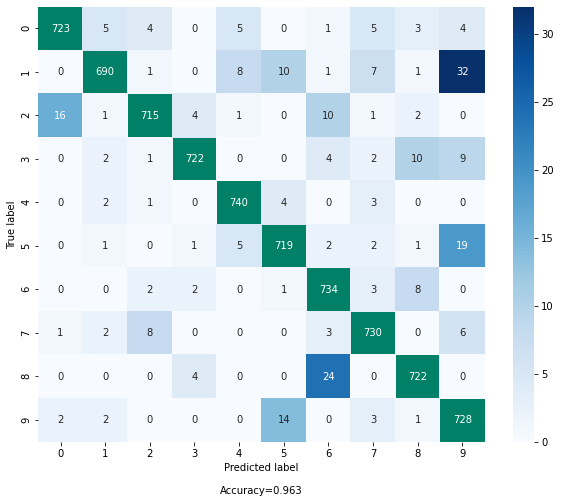

In [567]:
make_confusion_matrix(conf_matrix, percent=False, figsize=(10, 8))

In [574]:
class MyRecordingsDataset(Dataset):
    def __init__(self, path='my_recordings/'):
        super().__init__()

        self.NUM_TIME_SAMPLES = 14073  # равно числу отсчетов у самой короткой записи

        self.mode = 'test'

        self.audio = [
            (*librosa.load(f'{path}/{name}.m4a', sr=None), name)
            for name in range(10)
        ]

        self.unique_labels = np.arange(10)

        self.train_mean = -47.524658203125
        self.train_std = 18.497217178344727

    def __getitem__(self, i):
        label = self.audio[i][2]

        samples = self.audio[i][0]
        shift = (len(samples) - self.NUM_TIME_SAMPLES) // 2
        samples = samples[shift:shift + self.NUM_TIME_SAMPLES]
        spectrogram = melspectrogram_for_wav(samples, self.audio[i][1], n_fft, hop_length, n_mels)

        normalized_spectrogram = (spectrogram - train_mean) / train_std

        return torch.tensor(normalized_spectrogram, dtype=dtype).unsqueeze(0), label

    def __len__(self):
        return len(self.audio)

    def __repr__(self):
        return f'{self.mode} dataset, {len(self)} items, {len(self.unique_labels)} unique labels'

In [579]:
my_recordings_dataset = MyRecordingsDataset()
my_recordings_dataset

c:\users\alexander\envs\audio\lib\site-packages\librosa\core\audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


test dataset, 10 items, 10 unique labels

In [580]:
my_recordings_dataloader = DataLoader(my_recordings_dataset, batch_size=batch_size, shuffle=False)

In [581]:
# model.eval()

all_ys = []
all_preds = []

sum_loss = 0
sum_accuracy = 0
cnt_objects = 0

with torch.no_grad():
    for X, y in tqdm(my_recordings_dataloader):
        X = X.to(device)
        scores = model(X).cpu().squeeze(-1)
        loss = criterion(scores, y)
        sum_loss += loss * len(y)

        preds = scores.detach().argmax(dim=1)
        accuracy = (y == preds).float().mean()
        sum_accuracy += accuracy * len(y)

        cnt_objects += len(y)

        all_ys.append(y)
        all_preds.append(preds)

        print(
            f'Loss {loss.item():12.3f}, '
            f'accuracy {accuracy.item():5.3f}'
        )

mean_loss = sum_loss / cnt_objects
mean_accuracy = sum_accuracy / cnt_objects

  0%|          | 0/1 [00:00<?, ?it/s]

Loss        0.596, accuracy 0.700


In [582]:
all_ys

[tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])]

In [583]:
all_preds

[tensor([0, 1, 4, 9, 4, 2, 6, 7, 8, 9])]

ну почти :)

In [597]:
for x in scores:
    x = torch.softmax(x, dim=0)
    print(*[f'{q:7.3f}' for q in x])

  0.997   0.000   0.001   0.000   0.001   0.000   0.000   0.000   0.000   0.000
  0.000   0.982   0.000   0.000   0.002   0.013   0.000   0.000   0.000   0.003
  0.003   0.013   0.312   0.000   0.671   0.000   0.000   0.001   0.000   0.000
  0.007   0.004   0.007   0.411   0.000   0.002   0.000   0.000   0.003   0.566
  0.000   0.004   0.000   0.000   0.962   0.032   0.000   0.001   0.000   0.001
  0.132   0.001   0.366   0.055   0.120   0.022   0.272   0.014   0.016   0.001
  0.000   0.000   0.001   0.005   0.000   0.000   0.993   0.000   0.000   0.000
  0.000   0.000   0.000   0.000   0.000   0.000   0.000   1.000   0.000   0.000
  0.000   0.000   0.000   0.001   0.000   0.000   0.000   0.000   0.999   0.000
  0.000   0.003   0.000   0.000   0.000   0.036   0.000   0.000   0.000   0.961
